# FA22-BBD-010

# ALI AMMAR HAIDER

In [1]:
# Cell 1 – Clean setup for Google Colab (Python 3.12)

!pip install -q gradio

import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import load_model

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:
# Option A: Upload zip directly to Colab (small/medium files)
from google.colab import files
uploaded = files.upload()  # select your zip file when prompted

# It will return a dict mapping filename -> bytes. Find the zip filename:
zip_fname = next(iter(uploaded.keys()))
print("Uploaded:", zip_fname)

# Option B (alternative): if you put the zip in Google Drive, mount drive instead:
# from google.colab import drive
# drive.mount('/content/drive')
# zip_fname = '/content/drive/MyDrive/path/to/your/pneumonia_dataset.zip'


Saving Detection of Pneumonia Disease using Chest Radiogr.zip to Detection of Pneumonia Disease using Chest Radiogr.zip
Uploaded: Detection of Pneumonia Disease using Chest Radiogr.zip


In [3]:
# Cell 3 — Unzip your uploaded dataset

zip_path = "/content/Detection of Pneumonia Disease using Chest Radiogr.zip"
extract_path = "/content/dataset"

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")


Unzipped successfully!


In [4]:
# Cell 4 — View extracted folders/files

import os

for root, dirs, files in os.walk(extract_path):
    print(root, dirs, files)
    break


/content/dataset ['Detection of Pneumonia Disease using Chest Radiogr'] []


In [5]:
# Cell 4 — Inspect extracted folder structure deeply

import os

root = "/content/dataset/Detection of Pneumonia Disease using Chest Radiogr"

for path, dirs, files in os.walk(root):
    print("PATH:", path)
    print("DIRS:", dirs)
    print("FILES:", files[:5])   # show first 5 files only
    print("-" * 60)


PATH: /content/dataset/Detection of Pneumonia Disease using Chest Radiogr
DIRS: []
FILES: ['Chest_Radiograh Screeing (X-Ray).zip', 'NORMAL_Images.zip']
------------------------------------------------------------


In [6]:
# Cell 4 — Unzip inner ZIP files

import zipfile
import os

root = "/content/dataset/Detection of Pneumonia Disease using Chest Radiogr"
output_dir = "/content/dataset/pneumonia_data"

os.makedirs(output_dir, exist_ok=True)

# List all zip files inside the folder
zip_files = [f for f in os.listdir(root) if f.endswith(".zip")]
print("Found ZIP files:", zip_files)

for z in zip_files:
    z_path = os.path.join(root, z)
    print("Unzipping:", z_path)

    with zipfile.ZipFile(z_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

print("Extraction completed!")
print("Final dataset path:", output_dir)


Found ZIP files: ['Chest_Radiograh Screeing (X-Ray).zip', 'NORMAL_Images.zip']
Unzipping: /content/dataset/Detection of Pneumonia Disease using Chest Radiogr/Chest_Radiograh Screeing (X-Ray).zip
Unzipping: /content/dataset/Detection of Pneumonia Disease using Chest Radiogr/NORMAL_Images.zip
Extraction completed!
Final dataset path: /content/dataset/pneumonia_data


In [7]:
# Cell 5 — Inspect the extracted structure again

import os

data_root = "/content/dataset/pneumonia_data"

for path, dirs, files in os.walk(data_root):
    print("PATH:", path)
    print("DIRS:", dirs)
    print("FILES:", files[:5])
    print("-" * 60)


PATH: /content/dataset/pneumonia_data
DIRS: ['NORMAL_Images', 'Chest_Radiograh Screeing (X-Ray)']
FILES: []
------------------------------------------------------------
PATH: /content/dataset/pneumonia_data/NORMAL_Images
DIRS: []
FILES: ['06.jpg', '04.jpg', '73.jpg', '97.jpg', '150.jpg']
------------------------------------------------------------
PATH: /content/dataset/pneumonia_data/Chest_Radiograh Screeing (X-Ray)
DIRS: []
FILES: ['IMG-20251102-WA0415.jpg', 'IMG-20251102-WA0326.jpg', 'IMG-20251102-WA0252.jpg', 'IMG-20251102-WA0412.jpg', 'IMG-20251102-WA0368.jpg']
------------------------------------------------------------


In [8]:
# Cell 6 — Prepare standard train/val structure

import os
import shutil
from sklearn.model_selection import train_test_split

data_root = "/content/dataset/pneumonia_data"
normal_dir = os.path.join(data_root, "NORMAL_Images")
pneumonia_dir = os.path.join(data_root, "Chest_Radiograh Screeing (X-Ray)")

base_dir = "/content/pneumonia_split"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")

# Make folders
for d in [train_dir, val_dir]:
    os.makedirs(os.path.join(d, "NORMAL"), exist_ok=True)
    os.makedirs(os.path.join(d, "PNEUMONIA"), exist_ok=True)

# Load image names
normal_images = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)]
pneumonia_images = [os.path.join(pneumonia_dir, f) for f in os.listdir(pneumonia_dir)]

# Train/Val split
train_norm, val_norm = train_test_split(normal_images, test_size=0.2, random_state=42)
train_pneu, val_pneu = train_test_split(pneumonia_images, test_size=0.2, random_state=42)

# Copy files
def copy_files(files, dest_folder):
    for f in files:
        shutil.copy(f, dest_folder)

copy_files(train_norm, os.path.join(train_dir, "NORMAL"))
copy_files(val_norm,   os.path.join(val_dir, "NORMAL"))

copy_files(train_pneu, os.path.join(train_dir, "PNEUMONIA"))
copy_files(val_pneu,   os.path.join(val_dir, "PNEUMONIA"))

print("Dataset split completed!")


Dataset split completed!


In [9]:
# Cell 7 — Data generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH = 32

train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1/255.)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary'
)

val_ds = val_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary'
)

train_ds.class_indices


Found 403 images belonging to 2 classes.
Found 101 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

In [10]:
# Cell 8 — CNN model

import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Cell 9 — Train the model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

model.save("/content/pneumonia_cnn.h5")

print("Training completed, model saved!")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.5866 - loss: 1.7984 - val_accuracy: 0.5941 - val_loss: 0.6659
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.6160 - loss: 0.6565 - val_accuracy: 0.6832 - val_loss: 0.6162
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.6644 - loss: 0.6146 - val_accuracy: 0.7228 - val_loss: 0.5553
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - accuracy: 0.7293 - loss: 0.5743 - val_accuracy: 0.7624 - val_loss: 0.5080
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - accuracy: 0.6832 - loss: 0.5606 - val_accuracy: 0.7624 - val_loss: 0.5044
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - accuracy: 0.7010 - loss: 0.5752 - val_accuracy: 0.7525 - val_loss: 0.4961
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.7320 - loss: 0.5581 - val_accuracy: 0.8020 - val_loss: 0.4667
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - accuracy: 0.7357 - loss: 0.5217 - val_accuracy: 0.8020 - val_loss:

Training completed, model saved!


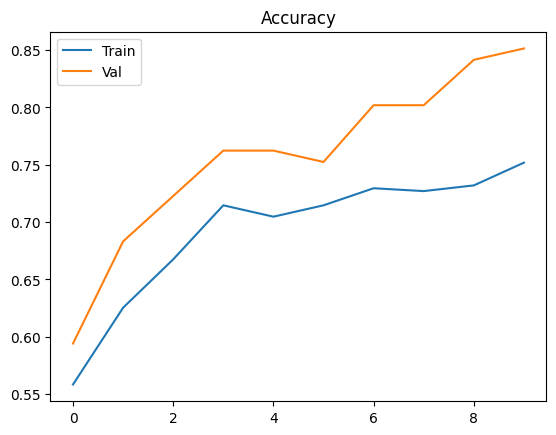

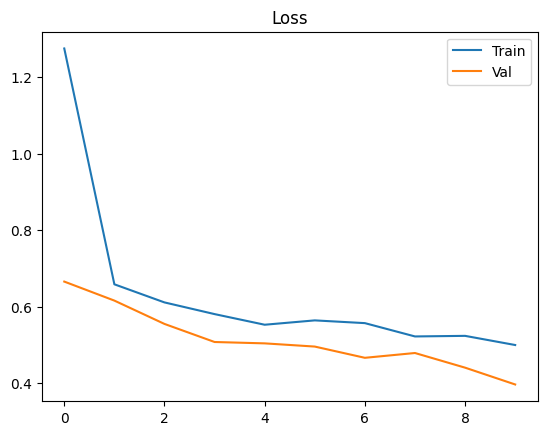

In [12]:
# Cell 10 — Plot training curves

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Train", "Val"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["Train", "Val"])
plt.show()


In [14]:
!pip install --upgrade gradio gradio_client


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: gradio
    Found existing installation: gradio 3.39.0
    Uninstalling gradio-3.39.0:
      Successfully uninstalled gradio-3.39.0


In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model("/content/pneumonia_cnn.h5")

def predict(img):
    img = img.resize((224,224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)[0][0]

    if pred > 0.5:
        return "🫁 PNEUMONIA DETECTED"
    else:
        return "✔ NORMAL LUNGS"

app = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Pneumonia Detector (CNN)"
)

app.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3381b83934ef628413.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
